# Sequence Characteristics Tutorial (LSOG / dyadic_children)

This tutorial shows how to use **Sequenzo's sequence characteristics** module with the **LSOG dyadic_children** dataset. You will learn:

1. **Setup** — Load data and build a `SequenceData` object
2. **Basic indicators** — Length, spell durations, visited states, recurrence, mean/std of durations
3. **Simple characteristics** — Number of transitions and distinct subsequences
4. **Entropy & complexity** — Within-sequence entropy, cross-sectional entropy, turbulence, complexity index
5. **Diversity & volatility** — Entropy difference, volatility
6. **Binary & integration** — Positive/negative indicators, integration index
7. **Ranked indicators** — Badness, degradation, precarity, insecurity (for ordered states)
8. **Cross-sectional** — Mean time in states, modal state sequence
9. **Visualization** — Longitudinal and cross-sectional plots

All functions return pandas DataFrames that you can use for further analysis. The API is designed to be consistent with **TraMineR** where applicable.

## 1. Load LSOG data and build SequenceData

We use the **dyadic_children** dataset (LSOG): state sequences with numeric time columns (ages 15–39) and an ID column `dyadID`. States are coded 1–6.

In [19]:
import pandas as pd
from sequenzo import SequenceData
from sequenzo.datasets import load_dataset

# Load the LSOG dyadic_children dataset
df = load_dataset("dyadic_children")

# Time columns are the numeric ones (ages 15 to 39)
time_list = sorted([c for c in df.columns if str(c).isdigit()], key=int)

# Define the state alphabet (1 to 6)
states = [1, 2, 3, 4, 5, 6]

# Build SequenceData: the main object for all sequence analyses
seqdata = SequenceData(
    df,
    time=time_list,
    id_col="dyadID",
    states=states,
)

print(f"Sequences: {seqdata.seqdata.shape[0]}, time points: {seqdata.seqdata.shape[1]}")
seqdata.seqdata.head()


[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 60
[>] Number of time points: 25
[>] Min/Max sequence length: 25 / 25
[>] States: [1, 2, 3, 4, 5, 6]
[>] Labels: ['1', '2', '3', '4', '5', '6']
[>] Weights: Not provided
Sequences: 60, time points: 25


,15,16,17,18,19,20,21,22,23,24,...,30,31,32,33,34,35,36,37,38,39
16,1,1,1,1,1,3,3,4,4,4,...,4,4,4,4,4,4,4,4,4,4
19,1,1,1,1,1,1,1,1,1,2,...,3,3,4,4,4,4,4,4,4,4
26,1,1,1,1,2,3,3,3,3,4,...,6,6,4,4,4,4,4,4,4,4
29,1,1,1,1,1,1,1,1,1,1,...,3,3,3,3,3,3,3,4,4,4
31,1,1,1,2,3,3,3,3,6,6,...,6,6,6,6,6,6,6,6,6,6


## 2. Basic indicators

These functions describe each sequence with simple numeric summaries.

### 2.1 Sequence length

**`get_sequence_length`** — Number of positions in each sequence (with or without counting missing).

In [20]:
from sequenzo.sequence_characteristics import get_sequence_length

length_df = get_sequence_length(seqdata, with_missing=True)
print("Sequence length (with_missing=True):")
length_df.head(10)

Sequence length (with_missing=True):


,ID,Length
0,16,25
1,19,25
2,26,25
3,29,25
4,31,25
5,43,25
6,54,25
7,75,25
8,82,25
9,94,25


### 2.2 Spell durations

**`get_spell_durations`** — For each sequence, the durations of every spell (run of the same state). Columns are `DUR1`, `DUR2`, ... (one per spell).

In [21]:
from sequenzo.sequence_characteristics import get_spell_durations

durations_df = get_spell_durations(seqdata, with_missing=False)
print("Spell durations (first few columns):")
durations_df.iloc[:, :5].head(10)

Spell durations (first few columns):


,DUR1,DUR2,DUR3,DUR4,DUR5
16,5,2.0,18.0,NaN,NaN
19,9,3.0,5.0,8.0,NaN
26,4,1.0,4.0,4.0,4.0
29,13,2.0,7.0,3.0,NaN
31,3,1.0,4.0,17.0,NaN
43,5,1.0,3.0,5.0,11.0
54,5,2.0,2.0,2.0,2.0
75,9,5.0,2.0,5.0,4.0
82,24,1.0,NaN,NaN,NaN
94,4,10.0,4.0,1.0,6.0


### 2.3 Visited states

**`get_visited_states`** — How many distinct states each sequence visits (`Visited`) and the proportion of the alphabet visited (`Visitp`).

In [22]:
from sequenzo.sequence_characteristics import get_visited_states

visited_df = get_visited_states(seqdata, with_missing=False)
visited_df.head(10)

[>] Computing state distribution for 60 sequences and 6 states ...


,ID,Visited,Visitp
0,0,3,0.500000
1,1,4,0.666667
2,2,5,0.833333
3,3,4,0.666667
4,4,4,0.666667
5,5,4,0.666667
6,6,6,1.000000
7,7,5,0.833333
8,8,2,0.333333
9,9,4,0.666667


### 2.4 Recurrence

**`get_recurrence`** — Recurrence index: how often the sequence returns to states already visited (repetition of states).

In [23]:
from sequenzo.sequence_characteristics import get_recurrence

recurrence_df = get_recurrence(seqdata, with_missing=False)
recurrence_df.head(10)

[>] Computing state distribution for 60 sequences and 6 states ...


,ID,Recu
0,16,1.000000
1,19,1.000000
2,26,1.200000
3,29,1.000000
4,31,1.000000
5,43,1.250000
6,54,1.333333
7,75,1.000000
8,82,1.000000
9,94,1.250000


### 2.5 Mean spell duration and standard deviation

**`get_mean_spell_duration`** — Average length of a spell. `type=1`: per sequence; `type=2`: per state (then averaged).  
**`get_duration_standard_deviation`** — Standard deviation of spell durations (same `type` option).

In [24]:
from sequenzo.sequence_characteristics import (
    get_mean_spell_duration,
    get_duration_standard_deviation,
)

mean_dur = get_mean_spell_duration(seqdata, type=1, with_missing=False)
std_dur = get_duration_standard_deviation(seqdata, type=1, with_missing=False)
print("Mean spell duration (type=1):")
print(mean_dur.head())
print("\nDuration standard deviation (type=1):")
print(std_dur.head())

Mean spell duration (type=1):
   ID     MeanD
0  16  8.333333
1  19  6.250000
2  26  4.166667
3  29  6.250000
4  31  6.250000

Duration standard deviation (type=1):
   ID     Dustd
0  16  6.944222
1  19  2.384848
2  26  2.034426
3  29  4.322904
4  31  6.299802


## 3. Simple characteristics: transitions and subsequences

**`get_number_of_transitions`** — Count how many times the state changes from one position to the next. Use `norm=True` to normalize by sequence length.

In [25]:
from sequenzo.sequence_characteristics import get_number_of_transitions

trans_df = get_number_of_transitions(seqdata, norm=False)
trans_norm = get_number_of_transitions(seqdata, norm=True)
print("Number of transitions (raw and normalized):")
compare = trans_df.copy()
compare["Transitions_norm"] = trans_norm["Transitions"].values
compare.head(10)

Number of transitions (raw and normalized):


,ID,Transitions,Transitions_norm
0,16,2,0.083333
1,19,3,0.125000
2,26,5,0.208333
3,29,3,0.125000
4,31,3,0.125000
5,43,4,0.166667
6,54,7,0.291667
7,75,4,0.166667
8,82,1,0.041667
9,94,4,0.166667


**`get_subsequences_all_sequences`** — Number of **distinct subsequences** in each sequence. With `dss=True`, consecutive identical states are merged first (distinct state sequence).

In [26]:
from sequenzo.sequence_characteristics import get_subsequences_all_sequences

subseq_df = get_subsequences_all_sequences(seqdata, dss=True, with_missing=False)
subseq_df.head(10)

,Subseq.
16,8
19,16
26,56
29,16
31,16
43,28
54,216
75,32
82,4
94,28


## 4. State frequencies and entropy per sequence

**`get_state_freq_and_entropy_per_seq`** — For each sequence: time (or proportion with `prop=True`) spent in each state. Useful to see how "spread" each sequence is over states.

In [27]:
from sequenzo.sequence_characteristics import get_state_freq_and_entropy_per_seq

freq_entropy = get_state_freq_and_entropy_per_seq(seqdata, prop=True)
print("State frequencies (proportions) per sequence:")
freq_entropy.head(10)

[>] Computing state distribution for 60 sequences and 6 states ...
State frequencies (proportions) per sequence:


,ID,1,2,3,4,5,6
0,16,0.20,0.00,0.08,0.72,0.00,0.00
1,19,0.36,0.12,0.20,0.32,0.00,0.00
2,26,0.16,0.04,0.16,0.48,0.00,0.16
3,29,0.52,0.08,0.28,0.12,0.00,0.00
4,31,0.12,0.04,0.16,0.00,0.00,0.68
5,43,0.20,0.24,0.44,0.00,0.00,0.12
6,54,0.20,0.08,0.08,0.08,0.20,0.36
7,75,0.36,0.20,0.08,0.20,0.16,0.00
8,82,0.96,0.04,0.00,0.00,0.00,0.00
9,94,0.16,0.40,0.40,0.00,0.00,0.04


## 5. Within-sequence entropy

**`get_within_sequence_entropy`** — Entropy of the state distribution within each sequence. `norm=True` gives normalized entropy in [0, 1].

In [28]:
from sequenzo.sequence_characteristics import get_within_sequence_entropy

within_ent = get_within_sequence_entropy(seqdata, norm=True)
within_ent.head(10)

,ID,Entropy
0,16,0.424426
1,19,0.730418
2,26,0.759421
3,29,0.643480
4,31,0.523871
5,43,0.714414
6,54,0.902880
7,75,0.840984
8,82,0.093731
9,94,0.644618


## 6. Cross-sectional entropy (over time)

**`get_cross_sectional_entropy`** — At each time point, entropy of the distribution of states across individuals. One value per time point (population diversity over time).

In [29]:
from sequenzo.sequence_characteristics import get_cross_sectional_entropy

cross_ent = get_cross_sectional_entropy(seqdata)
print("Cross-sectional entropy per time point:")
cross_ent.head(15)


Cross-Sectional Entropy Summary
[>] Number of states: 6
[>] Number of time points: 25
[>] On average, the most common state accounts for 43.1% of cases
[>] Entropy is highest at time point 30
[>] Entropy is lowest at time point 15
[>] Average normalized entropy: 0.760 (range: 0 = fully concentrated, 1 = evenly distributed)

Cross-sectional entropy per time point:


,time,state,freq,per_time_entropy_norm,N_valid,Effective States,rank,is_top
0,15,1,1.000000,0.000000,60.0,1.000000,1,True
1,15,2,0.000000,0.000000,60.0,1.000000,2,False
2,15,3,0.000000,0.000000,60.0,1.000000,3,False
3,15,4,0.000000,0.000000,60.0,1.000000,4,False
4,15,5,0.000000,0.000000,60.0,1.000000,5,False
5,15,6,0.000000,0.000000,60.0,1.000000,6,False
6,16,1,1.000000,0.000000,60.0,1.000000,1,True
7,16,2,0.000000,0.000000,60.0,1.000000,2,False
8,16,3,0.000000,0.000000,60.0,1.000000,3,False
9,16,4,0.000000,0.000000,60.0,1.000000,4,False


## 7. Variance of spell durations, turbulence, and complexity index

- **`get_spell_duration_variance`** — Variance of spell durations (option `type=1` or `2`).  
- **`get_turbulence`** — Turbulence index: captures how "chaotic" or unpredictable a sequence is.  
- **`get_complexity_index`** — Single complexity score combining entropy and number of transitions.

In [30]:
from sequenzo.sequence_characteristics import (
    get_spell_duration_variance,
    get_turbulence,
    get_complexity_index,
)

var_dur = get_spell_duration_variance(seqdata, type=1)
turb = get_turbulence(seqdata, norm=False, type=1, id_as_column=True)
complexity = get_complexity_index(seqdata)

print("Spell duration variance (type=1):")
print(var_dur["result"].head())
print("\nTurbulence:")
print(turb.head())
print("\nComplexity index:")
print(complexity.head())

[!] One or more missing values were found after calculating the number of distinct subsequences. They have been replaced with a large number of 1e15 to ensure the calculation continues.
Spell duration variance (type=1):
   ID  var_spell_dur
0  16      48.222222
1  19       5.687500
2  26       4.138889
3  29      18.687500
4  31      39.687500

Turbulence:
   ID  Turbulence
0  16    4.141052
1  19    7.645473
2  26    9.122247
3  29    6.087732
4  31    5.040427

Complexity index:
   ID  Complexity Index
0  16          0.188066
1  19          0.302163
2  26          0.397760
3  29          0.283611
4  31          0.255898


## 8. Longitudinal characteristics plot

**`plot_longitudinal_characteristics`** — Plots four normalized indicators (transitions, entropy, turbulence, complexity) for a selection of sequences. Great for comparing a few sequences side by side.

[!] One or more missing values were found after calculating the number of distinct subsequences. They have been replaced with a large number of 1e15 to ensure the calculation continues.


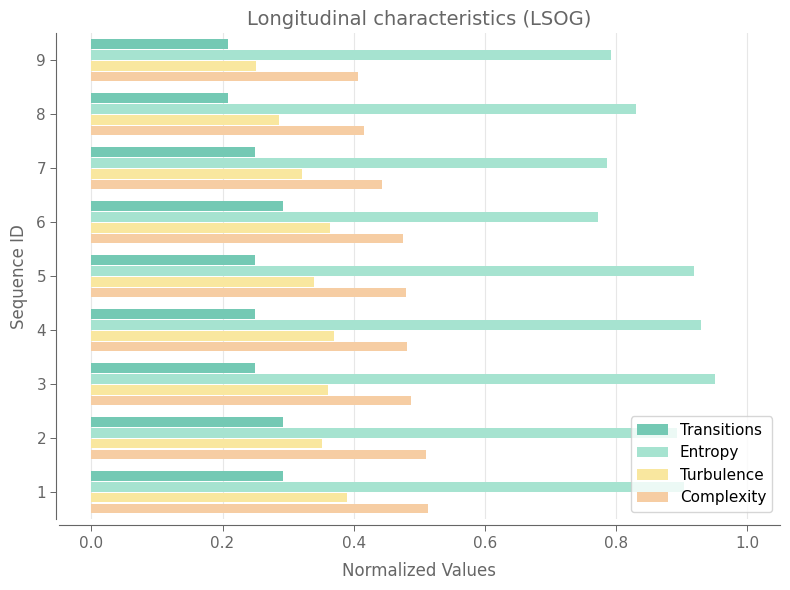

,ID,Transitions,Entropy,Turbulence,Complexity
0,54,0.291667,0.902880,0.389145,0.513167
1,131,0.291667,0.892702,0.352014,0.510266
2,300,0.250000,0.951151,0.360879,0.487635
3,442,0.250000,0.929043,0.369920,0.481934
4,101,0.250000,0.919555,0.339835,0.479467
5,184,0.291667,0.773047,0.364287,0.474839
6,275,0.250000,0.786274,0.321187,0.443360
7,252,0.208333,0.830848,0.285329,0.416045
8,152,0.208333,0.792829,0.251169,0.406414


In [31]:
from sequenzo.sequence_characteristics import plot_longitudinal_characteristics

# Plot 9 sequences, ordered by complexity (default)
plot_longitudinal_characteristics(
    seqdata,
    k=9,
    selection="first",
    order_by="complexity",
    figsize=(8, 6),
    title="Longitudinal characteristics (LSOG)",
)

## 9. Entropy difference and volatility

- **`get_entropy_difference`** — Difference between the maximum possible entropy and the actual within-sequence entropy; `norm=True` gives a value in [0, 1].  
- **`get_volatility`** — Volatility index (sensitivity to state changes). `w` in [0, 1] weights the effect of transitions; `adjust=True` for adjusted volatility.

In [32]:
from sequenzo.sequence_characteristics import get_entropy_difference, get_volatility

ent_diff = get_entropy_difference(seqdata, norm=True)
volat = get_volatility(seqdata, w=0.5, with_missing=False, adjust=True)
print("Entropy difference (normalized):")
print(ent_diff.head())
print("\nVolatility:")
print(volat.head())

[>] Computing state distribution for 60 sequences and 6 states ...
Entropy difference (normalized):
   ID      Hdss
0  16  0.236253
1  19  0.406581
2  26  0.517642
3  29  0.358188
4  31  0.291608

Volatility:
   ID     Volat
0  16  0.241667
1  19  0.362500
2  26  0.504167
3  29  0.362500
4  31  0.362500


## 10. Binary indicators: positive vs negative states

**`get_positive_negative_indicators`** — You define which states are "positive" and "negative". The function returns indices such as the **share** of time in positive states (or other indices). Useful for well-being or quality-of-life style outcomes.

In [33]:
from sequenzo.sequence_characteristics import get_positive_negative_indicators

# Example: states 1,2,3 = positive; 4,5,6 = negative (you can adapt to your labels)
pos_states = [1, 2, 3]
neg_states = [4, 5, 6]

pn_df = get_positive_negative_indicators(
    seqdata,
    pos_states=pos_states,
    neg_states=neg_states,
    index="share",
    dss=False,
    with_missing=False,
)
pn_df.head(10)

,ID,share
0,16,0.28
1,19,0.68
2,26,0.36
3,29,0.88
4,31,0.32
5,43,0.88
6,54,0.36
7,75,0.64
8,82,1.00
9,94,0.96


## 11. Integration index

**`get_integration_index`** — For each state (or a single state), measures how "integrated" that state is in the sequence (e.g. whether it appears in one block or is scattered). `state=None` returns a column per state.

In [34]:
from sequenzo.sequence_characteristics import get_integration_index

# All states
integ_all = get_integration_index(seqdata, state=None, pow=1.0, with_missing=False)
integ_all.head(10)

# Single state (e.g. state 1)
integ_s1 = get_integration_index(seqdata, state=1, pow=1.0, with_missing=False)
integ_s1.head(10)

,ID,State1
0,16,0.046154
1,19,0.138462
2,26,0.030769
3,29,0.280000
4,31,0.018462
5,43,0.046154
6,54,0.046154
7,75,0.138462
8,82,0.923077
9,94,0.030769


## 12. Ranked indicators (when states have a natural order)

These indices assume states can be ordered (e.g. from "best" to "worst"). They are often used in life-course or employment quality research.

- **`get_badness_index`** — How "bad" the sequence is (e.g. time in undesirable states).  
- **`get_degradation_index`** — Captures downward moves (degradation) in the state order.  
- **`get_precarity_index`** — Precarity (instability / exposure to bad states).  
- **`get_insecurity_index`** — Insecurity (e.g. risk of being in worse states).

In [35]:
from sequenzo.sequence_characteristics import (
    get_badness_index,
    get_degradation_index,
    get_precarity_index,
    get_insecurity_index,
)

bad = get_badness_index(seqdata, pow=1.0, with_missing=False)
degrad = get_degradation_index(seqdata, method="RANK", penalized="BOTH", pow=1.0, with_missing=False)
prec = get_precarity_index(seqdata, method="TRATEDSS", pow=1.0, with_missing=False)
insec = get_insecurity_index(seqdata, method="RANK", pow=1.0, with_missing=False)

print("Badness index:")
print(bad.head())
print("\nDegradation index:")
print(degrad.head())
print("\nPrecarity index:")
print(prec.head())
print("\nInsecurity index:")
print(insec.head())


[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 60
[>] Number of time points: 25
[>] Min/Max sequence length: 25 / 25
[>] States: [1, 2, 3, 4, 5, 6]
[>] Labels: ['1', '2', '3', '4', '5', '6']
[>] Weights: Not provided

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 60
[>] Number of time points: 25
[>] Min/Max sequence length: 25 / 25
[>] States: [1, 2, 3, 4, 5, 6]
[>] Labels: ['1', '2', '3', '4', '5', '6']
[>] Weights: Not provided

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 60
[>] Number of time points: 25
[>] Min/Max sequence length: 25 / 25
[>] States: [1, 2, 3, 4, 5, 6]
[>] Labels: ['1', '2', '3', '4', '5', '6']
[>] Weights: Not provided

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 60
[>] Number of time points: 25
[>] Min/Max sequence length: 25 / 25
[>] States: [1, 2, 3, 4, 5, 6]
[>] Labels: ['1', '2', '3', '4', '5', '6'

## 13. Cross-sectional indicators

These summarize the **population** at each time point (or over time), not per sequence.

- **`get_mean_time_in_states`** — Average time (or proportion) spent in each state across individuals.  
- **`get_modal_state_sequence`** — The most frequent state at each time point (the "typical" path).

In [36]:
from sequenzo.sequence_characteristics import (
    get_mean_time_in_states,
    get_modal_state_sequence,
)

mean_time = get_mean_time_in_states(
    seqdata,
    weighted=True,
    with_missing=False,
    prop=True,
    serr=False,
)
print("Mean time (proportion) in each state across sequences:")
print(mean_time)

modal_seq = get_modal_state_sequence(seqdata, weighted=True, with_missing=False)
print("\nModal state sequence (most frequent state at each time):")
print(modal_seq)
print("Occurrences:", modal_seq.attrs.get("Occurrences", "N/A"))
print("Frequencies:", modal_seq.attrs.get("Frequencies", "N/A")[:5], "...")

[>] Computing state distribution for 60 sequences and 6 states ...
Mean time (proportion) in each state across sequences:
       Mean
1  0.396667
2  0.133333
3  0.129333
4  0.140667
5  0.099333
6  0.100667

Modal state sequence (most frequent state at each time):


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## 14. Cross-sectional entropy plot

**`plot_cross_sectional_characteristics`** — Plots cross-sectional entropy over time (how diverse the population is at each time point).

In [ ]:
from sequenzo.sequence_characteristics import plot_cross_sectional_characteristics

plot_cross_sectional_characteristics(
    seqdata,
    figsize=(10, 5),
    title="Cross-sectional entropy over time (LSOG)",
)

## 15. Quick reference: combine indicators for analysis

You can merge several indicators into one DataFrame and use them as predictors or outcomes (e.g. in regression or clustering).

In [ ]:
# Build a summary table: one row per sequence, one column per indicator
length = get_sequence_length(seqdata, with_missing=False)
trans = get_number_of_transitions(seqdata, norm=True)
within_ent = get_within_sequence_entropy(seqdata, norm=True)
turb = get_turbulence(seqdata, norm=True, type=1, id_as_column=True)
compl = get_complexity_index(seqdata)

summary = length.merge(trans, on="ID").merge(within_ent, on="ID")
summary = summary.merge(turb, on="ID").merge(compl, on="ID")

print("Summary of key indicators (first 10 sequences):")
summary.head(10)

---
**End of tutorial.** For more options (e.g. `pick_ids`, `order_by`, `save_as` for plots), see the function docstrings: `help(get_sequence_length)` or `help(plot_longitudinal_characteristics)`.